# DoorDash - Delivery Duration Prediction

### Contents
* [Assignment](#Assignment)
* [Data Description](#Data-Description)
* [Data Exploration](#Data-Exploration)
* [Remove Redundant and Collinear Features](#Remove-Redundant-and-Collinear-Features)
* [Multicollinearity Check](#Multicollinearity-Check)
* [Feature Selection](#Feature-Selection)
* [Apply Scaler](#Apply-Scaler)
* [Inverse Transform for Metric Comparison](#Inverse-Transform-for-Metric-Comparison)
* [Classical Machine Learning](#Classical-Machine-Learning)

### Assignment

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

* **Start:** the time consumer submits the order (created_at) to
* **End:** when the order will be delivered to the consumer (actual_delivery_time)

Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

* model(s) used,
* how you evaluated your model performance on the historical data,
* any data processing you performed on the data,
* feature engineering choices you made,
* other information you would like to share your modeling approach.

### Data Description
The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

#### Columns in historical_data.csv

* **Time features**

**market_id:** A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

**created_at:** Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)

**actual_delivery_time:** Timestamp in UTC when the order was delivered to the consumer

* **Store features**

**store_id:** an id representing the restaurant the order was submitted for

**store_primary_category:** cuisine category of the restaurant, e.g., italian, asian

**order_protocol:** a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

* **Order features**

**total_items:** total number of items in the order

**subtotal:** total value of the order submitted (in cents)

**num_distinct_items:** number of distinct items included in the order

**min_item_price:** price of the item with the least cost in the order (in cents)

**max_item_price:** price of the item with the highest cost in the order (in cents)

* **Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

**total_onshift_dashers:** Number of available dashers who are within 10 miles of the store at the time of order creation

**total_busy_dashers:** Subset of above total_onshift_dashers who are currently working on an order

**total_outstanding_orders:** Number of orders within 10 miles of this order that are currently being processed.

* **Predictions from other models**

We have predictions from other models for various stages of delivery process that we can use:

**estimated_order_place_duration:** Estimated time for the restaurant to receive the order from DoorDash (in seconds)

**estimated_store_to_consumer_driving_duration:** Estimated travel time between store and consumer (in seconds)


### Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('historical_data.csv')
data.head(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

# The dt.total_seconds() function is used to return total duration of each element expressed in seconds.
data['actual_total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

data.head(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0


In [5]:
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers']

In [6]:
data['estimated_non_prep_duration'] = data['estimated_store_to_consumer_driving_duration'] + data['estimated_order_place_duration']

In [7]:
data['market_id'].nunique()

6

In [8]:
data['store_id'].nunique()

6743

In [9]:
data['order_protocol'].nunique()

7

In [10]:
order_protocol_dummies = pd.get_dummies(data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head(3)

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0


In [11]:
market_id_dummies = pd.get_dummies(data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head(3)

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0


In [12]:
store_id_unique = data['store_id'].unique().tolist()
store_id_and_category = {store_id : data[data.store_id == store_id].store_primary_category.mode()
                        for store_id in store_id_unique}

In [13]:
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
data['nan_free_store_primary_category'] = data.store_id.apply(fill)

In [14]:
store_primary_category_dummies = pd.get_dummies(data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head(3)

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# drop unnecessary columns
train_df = data.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol"])
train_df.head(3)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0


In [16]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis =1)

train_df = train_df.astype('float32')
train_df.head(3)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028535,0.013687,0.073625,0.105705,0.027175,0.189502,0.034246,0.037816,0.064904,0.173167
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [19]:
# Check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df), axis = 0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [20]:
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)

train_df.dropna(inplace = True)

In [21]:
train_df.shape

(177070, 100)

### Remove Redundant and Collinear Features

<Axes: >

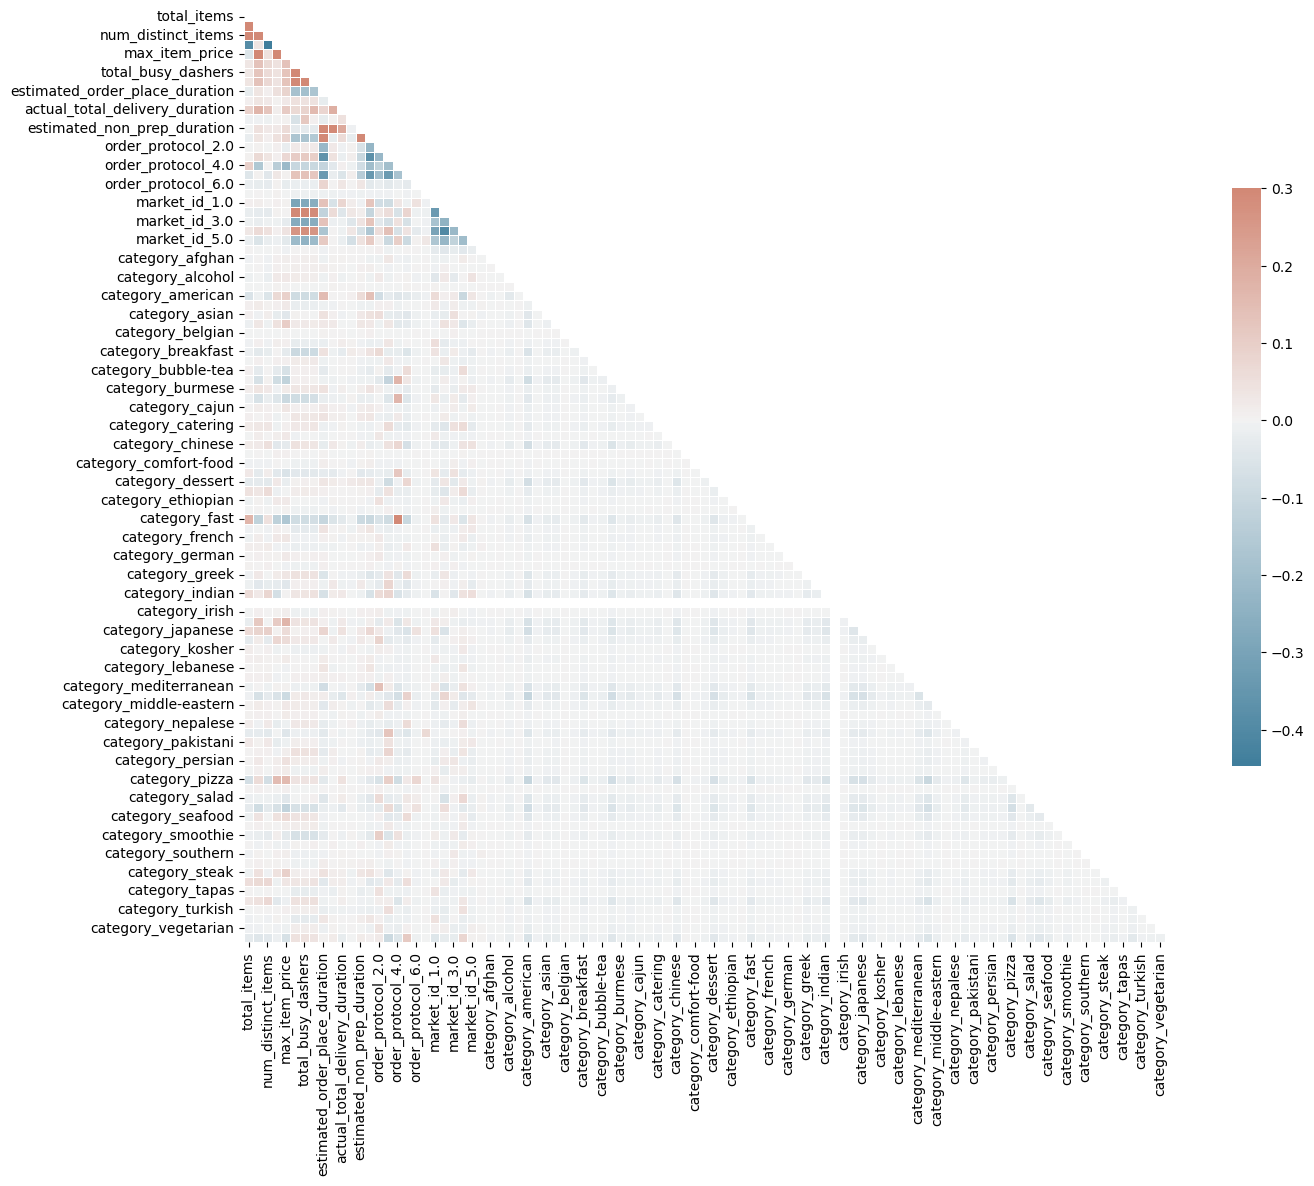

In [22]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (15,15))

cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
           square = True, linewidth = 0.5, cbar_kws = {"shrink" : 0.5})

In [23]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [24]:
def get_redundant_pairs(data_frame):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = data_frame.columns
    for i in range(0, data_frame.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(data_frame, n = 5):
    # Sort correlations in the descending order and return n highest results
    au_corr = data_frame.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data_frame)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

print('Top Absoulte Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absoulte Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items          

We have highly correlated features. We can drop some columns based on how much its information could be captured by other features.Firstly, total_busy_dashers and total_onshift_dashers are actually represented by busy_dashers_ratio. We can drop them off. Secondly, estimated_non_prep_duation - we created this feature - is correlated with driving and order place duration. We can keep the original value and drop the created one. Additionally, market id values are also on the list as being correlated with each other. As same with all kinds of colliniearities, these are potential suspects to hurt the regression performance. We won't concat them into the dataframe anymore

In [25]:
# Drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = data.drop(columns = ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                                         'nan_free_store_primary_category', 'order_protocol'])

# Don't concat market id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis = 1)

# Drop highly correlated features
train_df = train_df.drop(columns = ['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian',
                                   'estimated_non_prep_duration'])

# Align dtype over dataset
train_df = train_df.astype('float32')

# Replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace = True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
train_df.shape

(177070, 90)

In [27]:
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

It seems order protocols are also highly correlated with each other. We also won't concatenate them. Let's repeat the process one more time.

In [28]:
# Drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = data.drop(columns = ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                                         'nan_free_store_primary_category', 'order_protocol'])

# Don't concat market id
train_df = pd.concat([train_df, store_primary_category_dummies], axis = 1)

# Drop highly correlated features
train_df = train_df.drop(columns = ['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian',
                                   'estimated_non_prep_duration'])

# Align dtype over dataset
train_df = train_df.astype('float32')

# Replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace = True)

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

Still, we have some features with high correlations. The total item number or distinct items could affect the duration of the preparation process. Therefore, we do not prefer to drop them. Instead, we can use the power of feature engineering. We will create new columns to infer the contribution of these columns.


In [30]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']

train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']

train_df.drop(columns = ['num_distinct_items', 'subtotal'], inplace = True)

print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.17

We will apply a similar trick for min and max item prices.

In [31]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']

train_df.drop(columns = ['max_item_price', 'min_item_price'], inplace = True)

print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.15

In [32]:
train_df.shape

(177070, 82)

We solved the main issues with correlation. We are done with feature engineering now. We can officially apply a multicollinearity check in the next step. We reduced our number of columns to 82.

### Multicollinearity Check
We will check it through Variance Inflation Factor (VIF). We will eliminate all features that have VIF score above 20. For each iteration, we will drop only one feature, since when the feature set is changed VIF scores also change.


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
def compute_vif(features):
    # Compute VIF score using variance_inflation_factor() function
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(train_df[features].values, i)for i in range(len(features))]
    return vif_data.sort_values(by = ['VIF']).reset_index(drop = True)

In [35]:
features = train_df.drop(columns = ['actual_total_delivery_duration']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000490
2,category_belgian,1.000750
3,category_russian,1.003227
4,category_african,1.003820
...,...,...
76,busy_dashers_ratio,6.369593
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210814
79,estimated_order_place_duration,13.472032


We have a multicollinearity issue despite all our efforts in the feature engineering part. Next, we will drop the columns with the VIF score over the threshold.

In [36]:
# Drop with highest vif score until all vif scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print('I will remove', highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True
    
    
selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000363
2,category_belgian,1.000451
3,category_russian,1.002018
4,category_gluten-free,1.002364
...,...,...
75,category_american,4.505927
76,avg_price_per_item,5.958957
77,busy_dashers_ratio,6.357884
78,estimated_store_to_consumer_driving_duration,7.192613


It was enough to just drop percent_distinct_item_of_total.

### Feature Selection


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [38]:
X = train_df[selected_features]
y = train_df['actual_total_delivery_duration']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

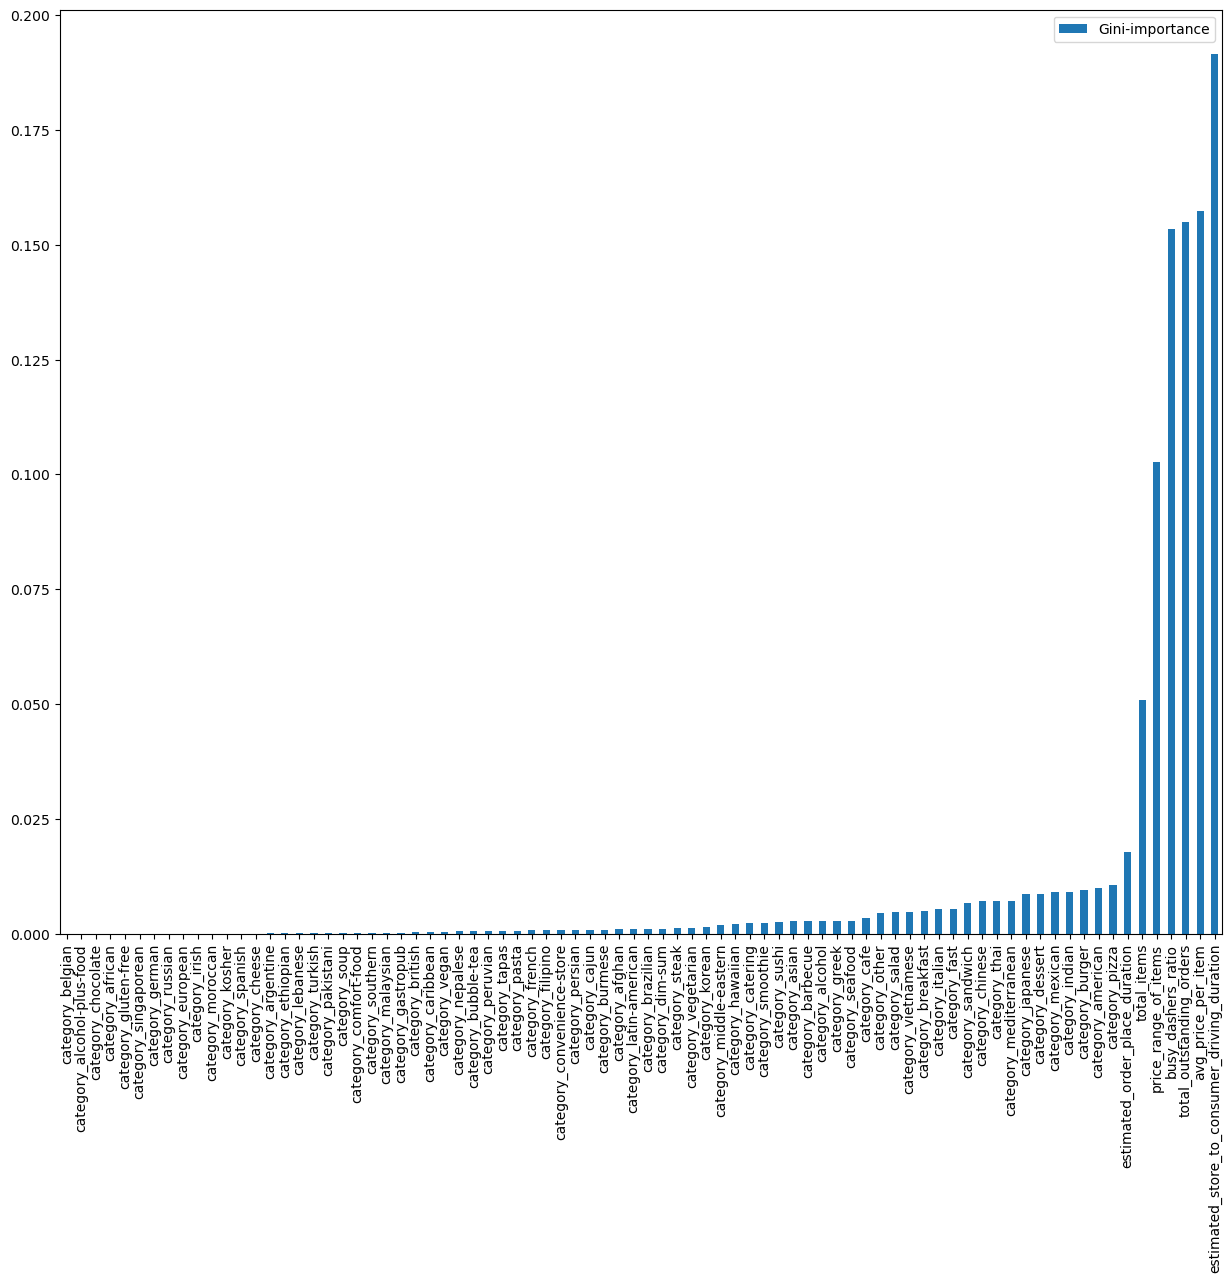

In [40]:
feature_name = [f"feature {i}" for i in range((X.shape[1]))]

random_forest = RandomForestRegressor(random_state = 42)

random_forest.fit(X_train, y_train)

feature_dict = {}  # A dictionary to hold feature_name : feature_importance

for feature,importance in zip(X.columns, random_forest.feature_importances_):
    feature_dict[feature] = importance  # Add the name/value pair
    
    
importances = pd.DataFrame.from_dict(feature_dict, orient = 'index').rename(columns = 
                                                                          {0 : 'Gini-importance'})
importances.sort_values(by = 'Gini-importance').plot(kind = 'bar', rot = 90, figsize = (15,12))
plt.show()

Many of the features have a very marginal contribution to regression. Let's check the most important ones.

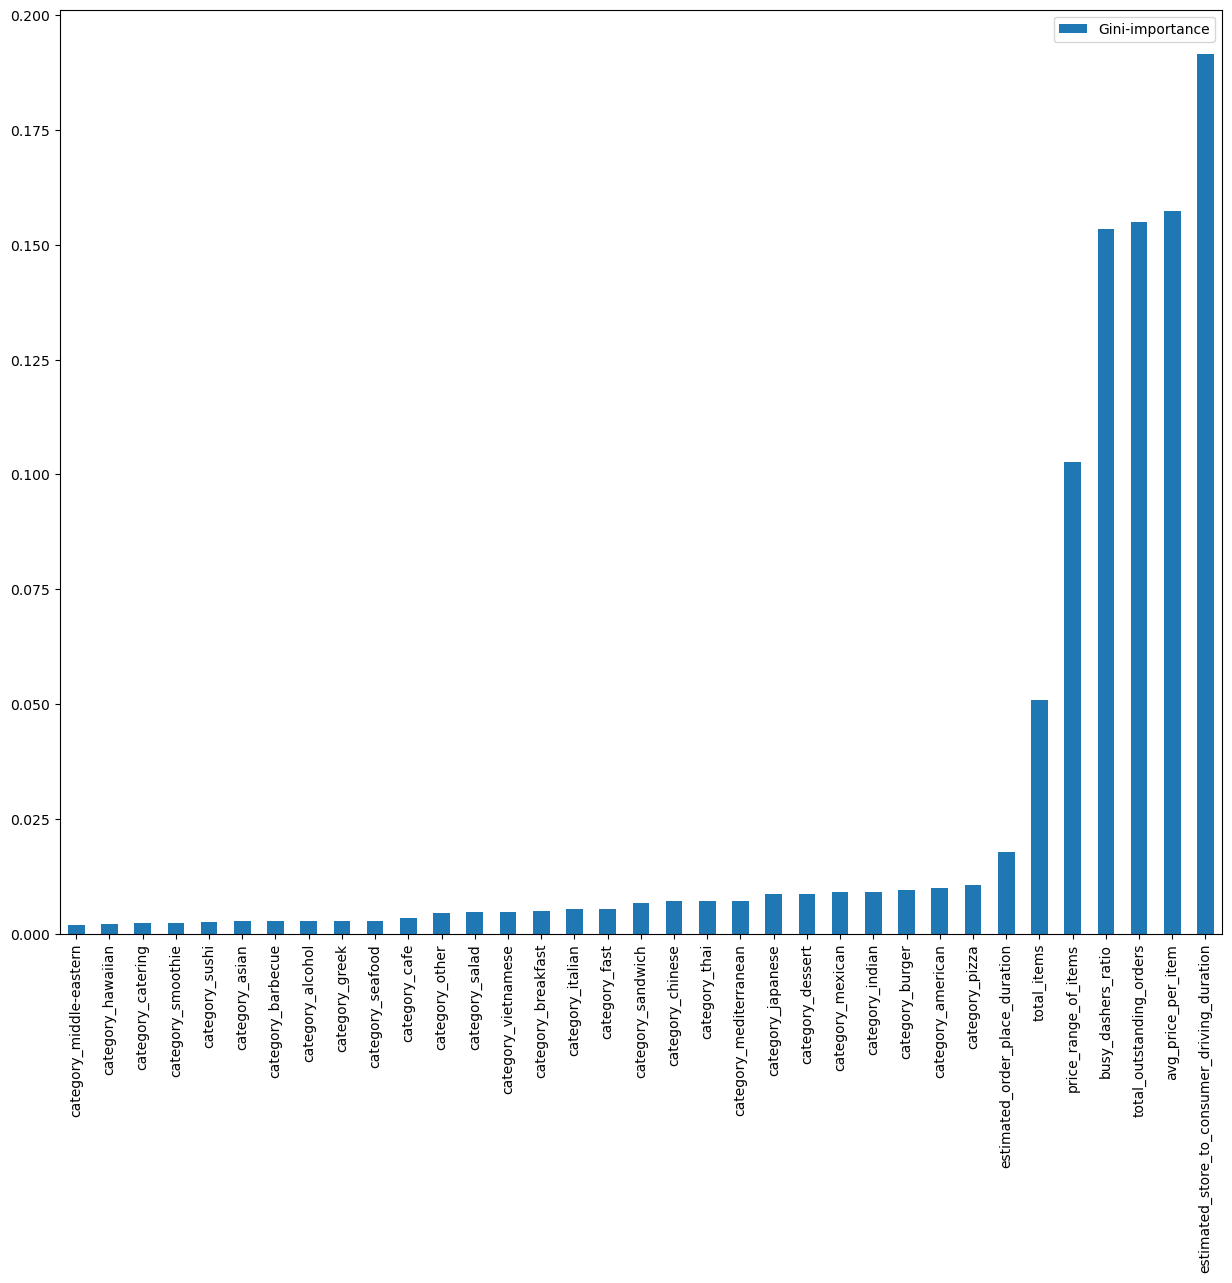

In [41]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

As expected, estimated store-to-consumer driving duration is very important to overall delivery duration. Busy dashers ratio, total outstanding orders, and average price per item are also highly contributed features. We can choose our final features subset using these importances.

In [42]:
importances.sort_values(by = 'Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

Another method to decrease feature dimension is PCA (Principal Component Analysis). It maps all features to another plain and obtains the most representative interpretations to explain all variances in the DataFrame.

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/var/folders/9q/jfjy60yj2tb9g_kpwyt_g0b80000gn/T/ipykernel_22822/3805794678.py:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


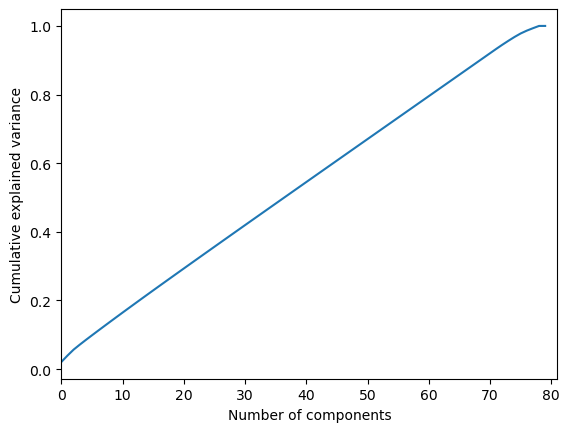

In [44]:
X_Train = X_train.values

X_Train = np.asarray(X_Train)

# Finding normalised array of X_Train
X_std = StandardScaler().fit_transform(X_Train)

pca = PCA().fit(X_std)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance. However, if PCA would tell us it can explain the majority of variance with around 10 features - high reduction - we would continue with it.

### Apply Scaler

In [45]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [46]:
def scale(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X = X, y = y)
    X_scaled = X_scaler.transform(X)
    
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [47]:
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [48]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, 
                                                                                test_size = 0.2, random_state = 42)

### Inverse Transform for Metric Comparison
Since we applied a scaler to training data, the predictions for test data will also be scaled. And to see the error in terms of seconds, we need to apply the inverse transformation. We will use Root Mean Squared Error to measure error. We could also use Mean Squared Error or Mean Absolute Error. We gave our decision based on the sensitivity of RMSE for high error terms. 

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    # Return RMSE with squared False
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared = False)
    
    print("Error = "'{}'.format(rmse_error) + " in " + model_name)
    
    return rmse_error, y_predict

### Classical Machine Learning

In [51]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose = True):
    # Apply selected regression model to data and measure error.
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared = False)
    
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared = False)
    
    if verbose:
        print("Train error = "'{}'.format(train_error) + " in " + model_name)
        print("Test error = "'{}'.format(test_error) + " in " + model_name)
    
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [52]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

In [53]:
pred_dict = {
    "regression_model" : [],
    "feature_set" : [],
    "scaler_name" : [],
    "RMSE" : [],
}

In [54]:
regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth = 6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost" : XGBRegressor(),
    "LGBM" : LGBMRegressor(),
    "MLP" : MLPRegressor(),
}

In [55]:
feature_sets = {
    "full dataset" : X.columns.to_list(),
    "selected_features_40" : importances.sort_values(by = 'Gini-importance')[-40 : ].index.tolist(),
    "selected_features_20" : importances.sort_values(by = 'Gini-importance')[-20 : ].index.tolist(),
    "selected_features_10" : importances.sort_values(by = 'Gini-importance')[-10 : ].index.tolist(),
}

In [56]:
scalers = {
    "Standard Scaler" : StandardScaler(),
    "MinMax Scaler" : MinMaxScaler(),
    "NotScale" : None,
}

In [57]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    
    for scaler_name in scalers.keys():
        print(f'-----scaled with {scaler_name}-------- included columns are {feature_set_name}')
        print('')
        
        for model_name in regression_models.keys():
            if scaler_name == 'NotScale':
                X = train_df[feature_set]
                y = train_df['actual_total_delivery_duration']
                
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose = True)
                
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled,
                                                                                               test_size = 0.2,
                                                                                               random_state = 42)
                
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled,
                                                          y_test_scaled[:,0], regression_models[model_name],
                                                          model_name, verbose = False)
                
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                
                
            
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)

-----scaled with Standard Scaler-------- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2048.5811782139504 in RandomForest
Error = 2036.2498779296875 in XGBoost
Error = 2033.4355809987908 in LGBM
Error = 2037.9542236328125 in MLP
-----scaled with MinMax Scaler-------- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2047.311198283287 in RandomForest
Error = 2035.351318359375 in XGBoost
Error = 2034.4499976619875 in LGBM
Error = 2155.802978515625 in MLP
-----scaled with NotScale-------- included columns are full dataset

Train error = 1071.4971923828125 in Ridge
Test error = 2053.692626953125 in Ridge


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.42537e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 396.0628067155322 in RandomForest
Test error = 2049.386959737166 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1054.1195068359375 in MLP
Test error = 2046.7860107421875 in MLP
-----scaled with Standard Scaler-------- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2048.2371872937156 in RandomForest
Error = 2035.453369140625 in XGBoost
Error = 2034.6538984910121 in LGBM
Error = 2037.876220703125 in MLP
-----scaled with MinMax Scaler-------- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2048.6688649078583 in RandomForest
Error = 2034.2847900390625 in XGBoost
Error = 2035.196536738781 in LGBM
Error = 2136.900634765625 in MLP
-----scaled with NotScale-------- included columns are selected_features_40

Train error = 1072.35498046875 in Ridge
Test error = 2054.00439453125 in Ridge


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.55924e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 396.58568507204154 in RandomForest
Test error = 2049.3713158442624 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1053.9310302734375 in MLP
Test error = 2046.9908447265625 in MLP
-----scaled with Standard Scaler-------- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2048.488824605207 in RandomForest
Error = 2037.6336669921875 in XGBoost
Error = 2036.0233846729805 in LGBM
Error = 2036.3021240234375 in MLP
-----scaled with MinMax Scaler-------- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2048.1602365657004 in RandomForest
Error = 2036.5164794921875 in XGBoost
Error = 2035.581516471472 in LGBM
Error = 2086.026123046875 in MLP
-----scaled with NotScale-------- included columns are selected_features_20

Train error = 1074.506591796875 in Ridge
Test error = 2055.36572265625 in Ridge


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.4386e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 396.78603242199796 in RandomForest
Test error = 2047.291998736045 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM
Train error = 1057.367919921875 in MLP
Test error = 2049.08984375 in MLP
-----scaled with Standard Scaler-------- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2052.99692811083 in RandomForest
Error = 2040.27001953125 in XGBoost
Error = 2038.1313604554389 in LGBM
Error = 2039.7513427734375 in MLP
-----scaled with MinMax Scaler-------- included columns are selected_features_10

Error = 2056.882080078125 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2050.8987643796067 in RandomForest
Error = 2039.515625 in XGBoost
Error = 2037.6564489201091 in 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
pred_data = pd.DataFrame(pred_dict)
pred_data

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard Scaler,2053.698730
1,DecisionTree,full dataset,Standard Scaler,2057.247669
2,RandomForest,full dataset,Standard Scaler,2048.581178
3,XGBoost,full dataset,Standard Scaler,2036.249878
4,LGBM,full dataset,Standard Scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2071.577637
68,RandomForest,selected_features_10,NotScale,2071.577637
69,XGBoost,selected_features_10,NotScale,2071.577637
70,LGBM,selected_features_10,NotScale,2071.577637


<Axes: >

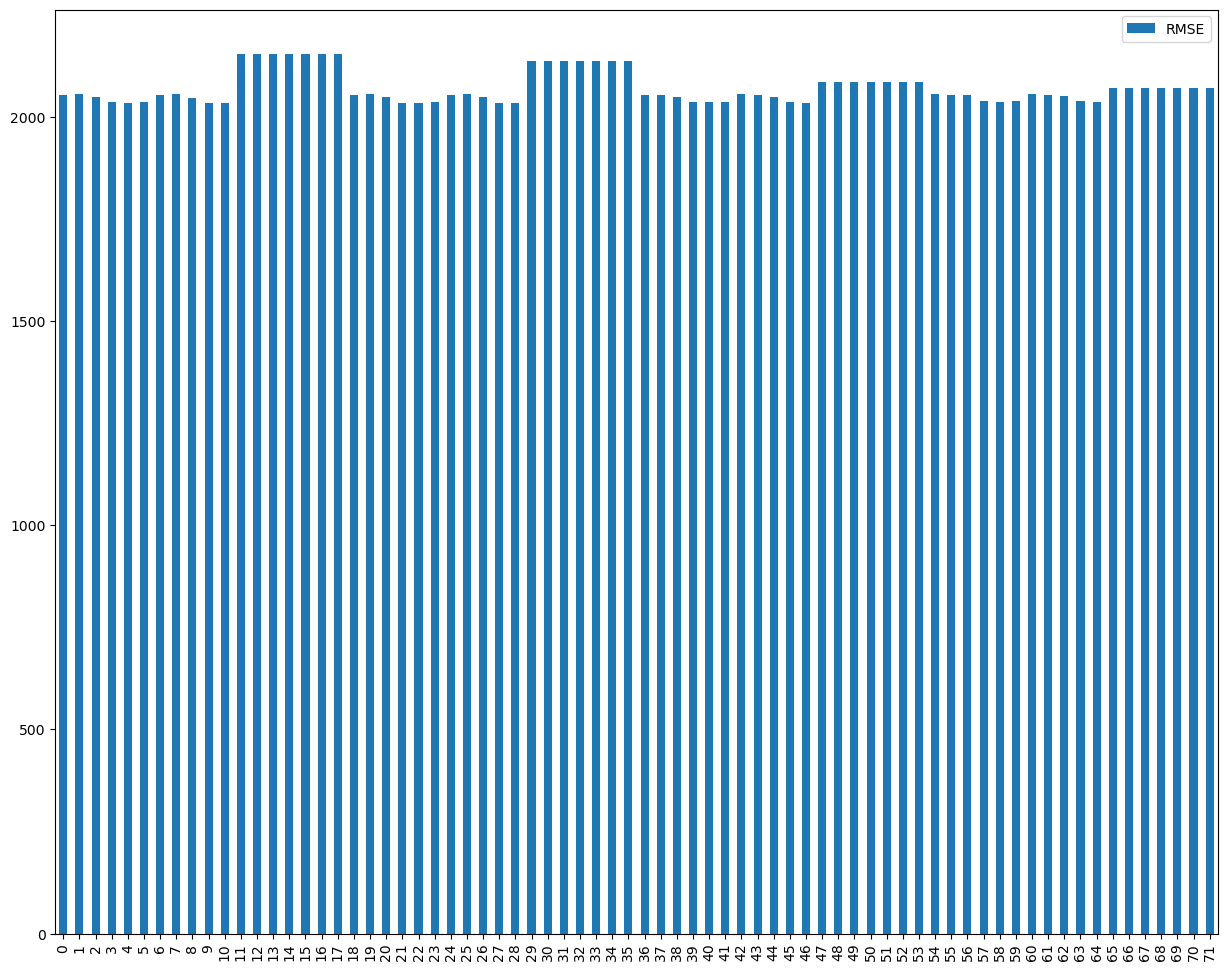

In [59]:
pred_data.plot(kind = 'bar', figsize = (15,12))

It seems we have high errors through all models. Also, the models inform us to not scale affects the performance. We could pick one of the scalers and continue since it doesn't affect the performance much. The decrease in training feature size first slightly improves the performance and then marginally made it worse. We choose to use 40 as a final decision. When we examine the model performances, the most significant thing is the error rates. What we could do more to improve it? Could it be our dataset is not a good representative for estimating the total delivery duration? One idea could be predicting preparation time and using the given estimated store-to-consumer driving ratio and order place, to sum up, and find the total delivery duration. Let's try it.

In [60]:
train_df['prep_time'] = train_df['actual_total_delivery_duration'] - train_df['estimated_store_to_consumer_driving_duration'] - train_df['estimated_order_place_duration']

In [61]:
scaler = {
    'Standard Scaler' : StandardScaler(),
}

In [62]:
feature_sets = {
    'Selected_features_40' : importances.sort_values(by = 'Gini-importance')[-40:].index.tolist(),
}

In [63]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    
    for scaler_name in scaler.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        
        for model_name in regression_models.keys():
            # Drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            
            # To get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # Scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # Apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled,
                                                                                            test_size=0.2, 
                                                                                            random_state=42)
            
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, 
                                                        y_test_scaled[:,0], regression_models[model_name], 
                                                        model_name, verbose=False)
            
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            
            
            
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard Scaler-------- included columns are Selected_features_40

Error = 2055.40771484375 in Ridge
Error = 2063.3402827182467 in DecisionTree
Error = 2051.397983629367 in RandomForest
Error = 2037.8203125 in XGBoost
Error = 2035.7236370573405 in LGBM
Error = 2038.084716796875 in MLP


LGBM consistently performs best. Choose best perform model and extract the predictions for preparation duration

In [64]:
# Not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler" : StandardScaler(),
}

In [65]:
feature_sets = {
    "selected_features_40" : importances.sort_values(by = 'Gini-importance')[-40:].index.tolist(),
}

In [66]:
regression_models = {
    "LGBM" : LGBMRegressor(),
}

In [67]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        
        for model_name in regression_models.keys():  
            # Drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # To get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # Scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # Apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled,
                                                                                            test_size=0.2, 
                                                                                            random_state=42)
            
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled,
                                                        y_test_scaled[:,0], regression_models[model_name], 
                                                        model_name, verbose=False)
            
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            
            
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 2035.7236370573405 in LGBM


In [68]:
# Choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

In [69]:
# convert it to dataframe from dict
values_data = pd.DataFrame.from_dict(pred_values_dict)
values_data

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [70]:
values_data["sum_total_delivery_duration"] = values_data["prep_duration_prediction"] + values_data["estimated_store_to_consumer_driving_duration"] + values_data["estimated_order_place_duration"]
values_data

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [71]:
mean_squared_error(values_data["actual_total_delivery_duration"], values_data["sum_total_delivery_duration"], squared=False)

2035.7236370573405

In [72]:
X = values_data[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_data["actual_total_delivery_duration"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}

In [74]:
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(X_train, y_train, X_test, y_test,regression_models[model_name], 
                                        model_name, verbose=False)
    
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

RMSE of: LinearReg 986.6912510303845
RMSE of: Ridge 986.6912510344928
RMSE of: DecisionTree 1235.578088153976
RMSE of: RandomForest 1206.0508953811025
RMSE of: XGBoost 1370.412425918564
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.0643545536888


### Deep Learning

In [75]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

2023-05-02 19:29:28.908556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [76]:
# Neural network
def create_model(feature_set_size):
    
    # Define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [77]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")

model_name = "ANN"   

scaler_name = "Standard scaler"

X = values_data[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", 
               "estimated_order_place_duration"]]

y = values_data["actual_total_delivery_duration"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)


X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2,
                                                                                random_state=42)

print("feature_set_size:",X_train_scaled.shape[1])


model = create_model(feature_set_size=X_train_scaled.shape[1])


history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)


y_pred = model.predict(X_test_scaled)


rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)


pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 1s 744us/step - loss: 1.1529 - root_mean_squared_error: 1.0737
Epoch 2/100
443/443 [==============================] - 0s 721us/step - loss: 1.1211 - root_mean_squared_error: 1.0588
Epoch 3/100
443/443 [==============================] - 0s 713us/step - loss: 1.1191 - root_mean_squared_error: 1.0579
Epoch 4/100
443/443 [==============================] - 0s 710us/step - loss: 1.1186 - root_mean_squared_error: 1.0576
Epoch 5/100
443/443 [==============================] - 0s 710us/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 6/100
443/443 [==============================] - 0s 707us/step - loss: 1.1180 - root_mean_squared_error: 1.0574
Epoch 7/100
443/443 [==============================] - 0s 708us/step - loss: 1.1180 - root_mean_squared_error: 1.0573
Epoch 8/100
443/443 [==============================] - 0s 704us/step -

443/443 [==============================] - 0s 715us/step - loss: 1.1170 - root_mean_squared_error: 1.0569
Epoch 70/100
443/443 [==============================] - 0s 712us/step - loss: 1.1169 - root_mean_squared_error: 1.0568
Epoch 71/100
443/443 [==============================] - 0s 710us/step - loss: 1.1171 - root_mean_squared_error: 1.0569
Epoch 72/100
443/443 [==============================] - 0s 712us/step - loss: 1.1166 - root_mean_squared_error: 1.0567
Epoch 73/100
443/443 [==============================] - 0s 710us/step - loss: 1.1174 - root_mean_squared_error: 1.0571
Epoch 74/100
443/443 [==============================] - 0s 711us/step - loss: 1.1170 - root_mean_squared_error: 1.0569
Epoch 75/100
443/443 [==============================] - 0s 709us/step - loss: 1.1168 - root_mean_squared_error: 1.0568
Epoch 76/100
443/443 [==============================] - 0s 710us/step - loss: 1.1167 - root_mean_squared_error: 1.0568
Epoch 77/100
443/443 [==============================] - 0s 70

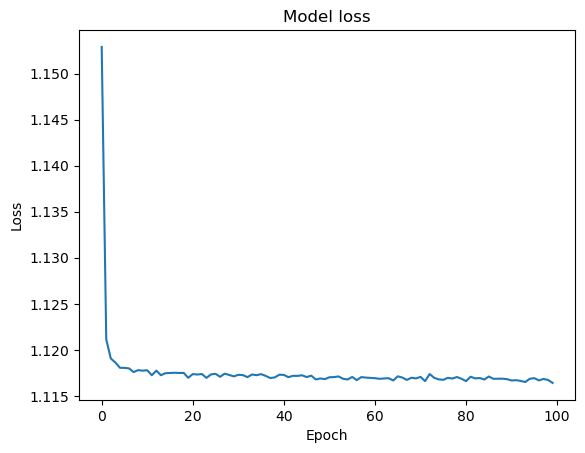

In [78]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()

We achieved the same performance with the MLP method of sklearn. It could be possible to improve the performance a bit more with hyperparameter tuning in ANN, however, it requires considerable time and effort. Would it be a better approach when we already have a good performance Linear Regression model which is very simple and fast? It is a design choice. We leave our official solution as LGBM + Linear Regression on top.